# Steam Game Recommendation System

## Overview

The Steam Game Recommendation System transforms the gaming experience on Steam by utilizing algorithms to analyze user behavior and preferences. Through personalized game recommendations based on collaborative filtering and historical data, the system enhances game discoverability, deepening the connection between users and Steam's extensive game library. This approach not only boosts user satisfaction and engagement but also strategically contributes to revenue growth through targeted recommendations and increased game sales. The system stands as a pioneering force in delivering a tailored and immersive gaming journey, ensuring users find their perfect match in Steam's diverse game catalog.

## Business Understanding

The Steam Game Recommendation System aims to enhance user engagement and satisfaction on the Steam gaming platform. By leveraging collaborative filtering techniques, user preferences, and historical gameplay data, the system seeks to provide personalized game recommendations tailored to each user's unique gaming preferences. The primary business goal is to increase game discoverability, leading to higher user retention and increased revenue through game sales. 
Additionally, the recommendation system contributes to creating a more immersive and enjoyable gaming experience for Steam users by connecting them with titles that align with their interests and gaming habits. Overall, the system aims to foster a stronger connection between gamers and the diverse range of games available on the Steam platform.

## Data Exploration and Analysis 

In [5]:
pip install surprise

Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import numpy as np
import json
import re
import seaborn as sns
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt

from surprise import Dataset, Reader, NormalPredictor , SVD , KNNWithMeans , SVDpp
from surprise.model_selection import cross_validate

import random
from collections import defaultdict
import gradio as gr
import pickle

read csv file from data folder

In [2]:
steam_df = pd.read_csv('./data/steam-200k.csv', header=None, index_col=None, names=['UserID', 'Game', 'Action', 'Hours', 'Other'])

In [3]:
steam_df.head(25)

,UserID,Game,Action,Hours,Other
0,151603712,The Elder Scrolls V Skyrim,purchase,1.0,0
1,151603712,The Elder Scrolls V Skyrim,play,273.0,0
2,151603712,Fallout 4,purchase,1.0,0
3,151603712,Fallout 4,play,87.0,0
4,151603712,Spore,purchase,1.0,0
5,151603712,Spore,play,14.9,0
6,151603712,Fallout New Vegas,purchase,1.0,0
7,151603712,Fallout New Vegas,play,12.1,0
8,151603712,Left 4 Dead 2,purchase,1.0,0
9,151603712,Left 4 Dead 2,play,8.9,0


In [4]:
steam_df.value_counts()

UserID     Game                                          Action    Hours  Other
93275329   Grand Theft Auto Vice City                    purchase  1.0    0        2
116876958  Grand Theft Auto III                          purchase  1.0    0        2
27169419   Sid Meier's Civilization IV Beyond the Sword  purchase  1.0    0        2
           Sid Meier's Civilization IV                   purchase  1.0    0        2
46028967   Sid Meier's Civilization IV                   purchase  1.0    0        2
                                                                                  ..
127072755  Mortal Kombat Komplete Edition                purchase  1.0    0        1
                                                         play      0.3    0        1
           Just Cause 2 Multiplayer Mod                  purchase  1.0    0        1
                                                         play      0.7    0        1
5250       Alien Swarm                                   play      4.9

In [5]:
play_data = steam_df[steam_df['Action'] == 'play']

In [6]:
play_data_new = play_data.drop(['Action', 'Other'], axis=1)

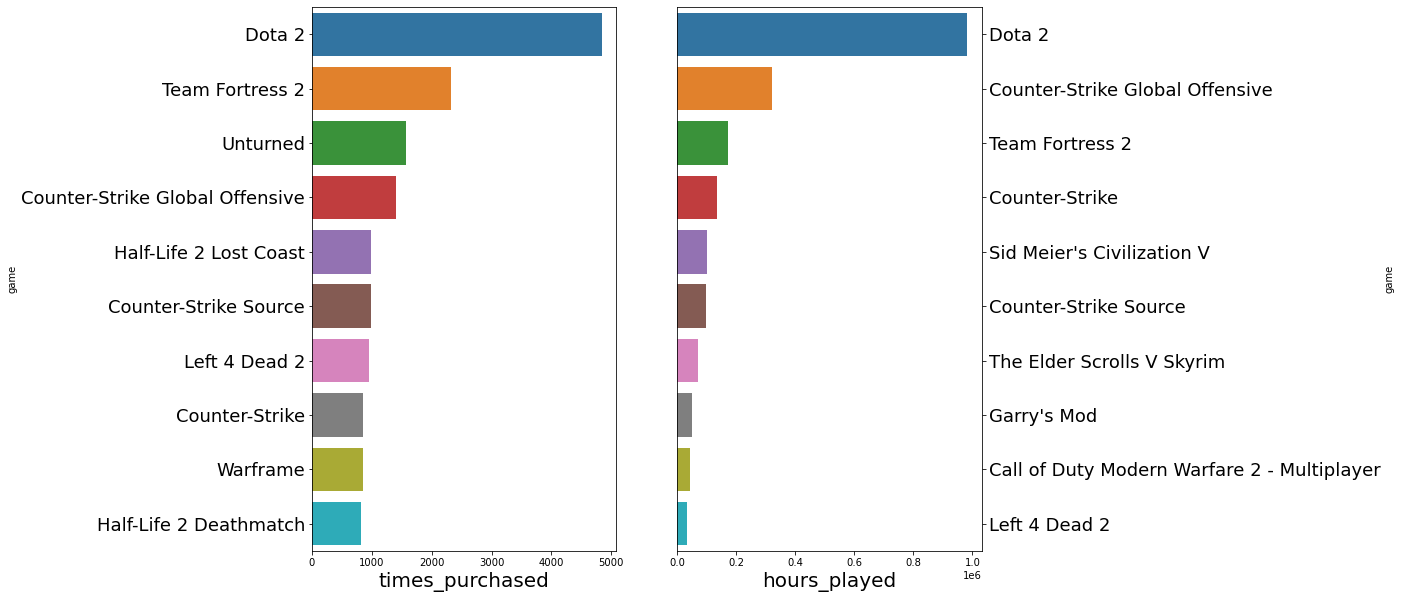

In [7]:
nb_games = 10
df_purchase = steam_df.loc[steam_df['Action'] == 'purchase']
purchased_times = df_purchase.groupby('Game')['Game'].agg('count').sort_values(ascending=False)
purchased_times = pd.DataFrame({'game': purchased_times.index, 'times_purchased': purchased_times.values})[0:nb_games]

play_data = steam_df[steam_df['Action'] == 'play']
hours_played = play_data.groupby('Game')['Hours'].agg(np.sum).sort_values(ascending=False)
hours_played = pd.DataFrame({'game': hours_played.index, 'hours_played': hours_played.values})[0:nb_games]

fig, ax = plt.subplots(1,2,figsize=(12,nb_games))

sns.barplot(y = 'game', x = 'times_purchased', data = purchased_times, ax=ax[0])
sns.barplot(y = 'game', x = 'hours_played', data = hours_played, ax=ax[1])


ax[1].yaxis.tick_right()
ax[1].yaxis.set_label_position("right")
for i in range(0,2):
    ax[i].tick_params(axis='y', labelsize=18)
    ax[i].xaxis.label.set_size(20)

# Plotting code here is adopted from Kaggle notebook https://www.kaggle.com/code/simonprevoteaux/steam-game-analysis

These barcharts show the top games played by user to `times_purchased` and `hours_played` respectively

Introduce a `"min_hours"` and `"max_hours"` column to establish a user rating system based on the minimum and maximum hours played for each game.

In [8]:
game_hours_min_max = play_data_new.groupby('Game')['Hours'].agg(['min', 'max']).reset_index()

In [9]:
# Define a new function for cumulative hours to fit the rating system
# Recalculate the total hours played for each game across all users
# Create a DataFrame for the rating of each game
game_hours_min_max.columns = ['Game', 'Min_Hours', 'Max_Hours']

# Merge this with the original play_data_new DataFrame
play_data_agg_min_max = play_data_new.merge(game_hours_min_max, on='Game')

play_data_agg_min_max.head()

,UserID,Game,Hours,Min_Hours,Max_Hours
0,151603712,The Elder Scrolls V Skyrim,273.0,0.1,1986.0
1,59945701,The Elder Scrolls V Skyrim,58.0,0.1,1986.0
2,92107940,The Elder Scrolls V Skyrim,110.0,0.1,1986.0
3,250006052,The Elder Scrolls V Skyrim,465.0,0.1,1986.0
4,11373749,The Elder Scrolls V Skyrim,220.0,0.1,1986.0


In [10]:
play_data_agg_min_max.tail(50)

,UserID,Game,Hours,Min_Hours,Max_Hours
70439,154230723,Aces Wild Manic Brawling Action!,0.2,0.2,0.5
70440,231416829,D4 Dark Dreams Don't Die,0.5,0.5,0.5
70441,20772968,BloodRayne,6.6,6.6,6.6
70442,20772968,Carmageddon Max Pack,2.8,2.8,2.8
70443,20772968,Coniclysm,0.3,0.3,0.3
70444,20772968,Alien Shooter Revisited,0.1,0.1,0.1
70445,213854339,Eastside Hockey Manager,1295.0,1295.0,1295.0
70446,213854339,Franchise Hockey Manager 2,11.2,11.2,11.2
70447,47384303,Kohan Immortal Sovereigns,7.9,7.9,7.9
70448,47384303,Avadon 2 The Corruption,2.9,2.9,2.9


In [11]:
filtered_data = play_data_agg_min_max.loc[play_data_agg_min_max['Min_Hours'] != play_data_agg_min_max['Max_Hours']]

In [12]:
filtered_data

,UserID,Game,Hours,Min_Hours,Max_Hours
0,151603712,The Elder Scrolls V Skyrim,273.0,0.1,1986.0
1,59945701,The Elder Scrolls V Skyrim,58.0,0.1,1986.0
2,92107940,The Elder Scrolls V Skyrim,110.0,0.1,1986.0
3,250006052,The Elder Scrolls V Skyrim,465.0,0.1,1986.0
4,11373749,The Elder Scrolls V Skyrim,220.0,0.1,1986.0
...,...,...,...,...,...
70424,60859695,Nancy Drew Ghost Dogs of Moon Lake,5.9,4.3,5.9
70436,162081645,Haunt the House Terrortown,1.3,0.8,1.3
70437,154230723,Haunt the House Terrortown,0.8,0.8,1.3
70438,142793906,Aces Wild Manic Brawling Action!,0.5,0.2,0.5


### Here we will create ratings with min/max scaling 

In [13]:
def ratings_normalize(d):
    new_series = d['Hours'] / d['Max_Hours']
    return new_series

In [14]:
filtered_data['Hours']

0        273.0
1         58.0
2        110.0
3        465.0
4        220.0
         ...  
70424      5.9
70436      1.3
70437      0.8
70438      0.5
70439      0.2
Name: Hours, Length: 69432, dtype: float64

Create a `'Rating'` column by relativly measuring how much a user has played a particular game in comparison to the maximum hours played across all games by that user.

In [15]:
filtered_data['Ratings'] = filtered_data.apply(lambda x: (x["Hours"] / x["Max_Hours"]), axis=1)

<ipython-input-15-aef263175d1c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['Ratings'] = filtered_data.apply(lambda x: (x["Hours"] / x["Max_Hours"]), axis=1)


In [16]:
filtered_data

,UserID,Game,Hours,Min_Hours,Max_Hours,Ratings
0,151603712,The Elder Scrolls V Skyrim,273.0,0.1,1986.0,0.137462
1,59945701,The Elder Scrolls V Skyrim,58.0,0.1,1986.0,0.029204
2,92107940,The Elder Scrolls V Skyrim,110.0,0.1,1986.0,0.055388
3,250006052,The Elder Scrolls V Skyrim,465.0,0.1,1986.0,0.234139
4,11373749,The Elder Scrolls V Skyrim,220.0,0.1,1986.0,0.110775
...,...,...,...,...,...,...
70424,60859695,Nancy Drew Ghost Dogs of Moon Lake,5.9,4.3,5.9,1.000000
70436,162081645,Haunt the House Terrortown,1.3,0.8,1.3,1.000000
70437,154230723,Haunt the House Terrortown,0.8,0.8,1.3,0.615385
70438,142793906,Aces Wild Manic Brawling Action!,0.5,0.2,0.5,1.000000


Export to csv file to save the filtered_steam_games

In [17]:
filtered_data_new = pd.read_csv('./data/filtered_steam_games.csv', index_col=[0])

## Modeling and Cross Validation

First we will prepare a baseline model with Normal Predictor from surprise

#### Normal Predictor

In [23]:
# Prepare the data for Surprise
reader = Reader(rating_scale=(filtered_data_new['Ratings'].min(), filtered_data_new['Ratings'].max()))
data = Dataset.load_from_df(filtered_data_new[['UserID', 'Game', 'Ratings']], reader)

# Define the NormalPredictor model
algo = NormalPredictor()

# Perform cross-validation and compute RMSE
results = cross_validate(algo, data, measures=['RMSE'], cv=5, verbose=True)

# Average RMSE
average_rmse = sum(results['test_rmse']) / len(results['test_rmse'])
print(f'Average RMSE using NormalPredictor: {average_rmse}')

Evaluating RMSE of algorithm NormalPredictor on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.2931  0.2961  0.2953  0.2932  0.2938  0.2943  0.0012  
Fit time          0.10    0.10    0.12    0.08    0.08    0.10    0.01    
Test time         0.10    0.08    0.10    0.12    0.18    0.12    0.04    
Average RMSE using NormalPredictor: 0.29427038560709273


#### SVD

In [24]:
# Define the Reader
reader = Reader(rating_scale=(0, 1))

# Load the dataset into Surprise
data = Dataset.load_from_df(filtered_data_new[['UserID', 'Game', 'Ratings']], reader)

# SVD algo
algo_svd = SVD()

# Perform cross-validation
svd_results = cross_validate(algo_svd, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.2140  0.2181  0.2144  0.2135  0.2151  0.2150  0.0016  
MAE (testset)     0.1249  0.1274  0.1263  0.1252  0.1255  0.1259  0.0009  
Fit time          2.97    3.42    3.49    3.49    4.08    3.49    0.35    
Test time         0.08    0.19    0.18    0.14    0.18    0.15    0.04    


#### KNNWithMeans

In [18]:
# Define the Reader
reader = Reader(rating_scale=(0, 1))

# Load the dataset into Surprise
data = Dataset.load_from_df(filtered_data_new[['UserID', 'Game', 'Ratings']], reader)

# Configure KNNWithMeans
algo_knnm = KNNWithMeans(sim_options={'name': 'cosine', 'user_based': True})

# Perform cross-validation
results_knnm = cross_validate(algo_knnm, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNWithMeans on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.2291  0.2268  0.2288  0.2267  0.2237  0.2270  0.0019  
MAE (testset)     0.1374  0.1367  0.1382  0.1376  0.1361  0.1372  0.0007  
Fit time          5.39    5.84    5.56    5.64    5.61    5.61    0.15    
Test time         0.91    0.97    0.88    0.92    0.94    0.92    0.03    


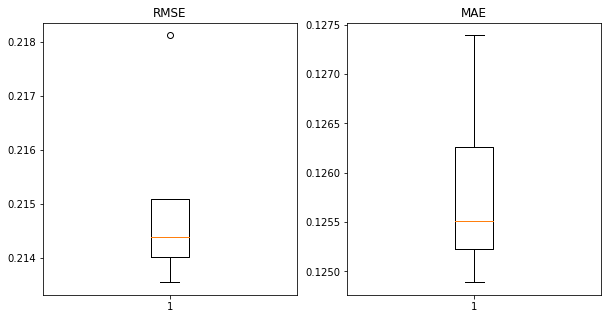

In [26]:
rmse = svd_results['test_rmse']
mae = svd_results['test_mae']

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.boxplot(rmse)
plt.title('RMSE')
plt.subplot(1, 2, 2)
plt.boxplot(mae)
plt.title('MAE')
plt.show()

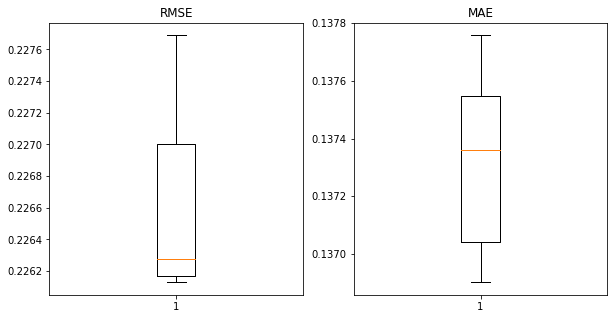

In [27]:
rmse = results_knnm['test_rmse']
mae = results_knnm['test_mae']

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.boxplot(rmse)
plt.title('RMSE')
plt.subplot(1, 2, 2)
plt.boxplot(mae)
plt.title('MAE')
plt.show()

Uncomment to run GridSearch
- GridsearchCV for SVD++

In [28]:
# from surprise import Dataset, Reader
# from surprise.model_selection import GridSearchCV
# from surprise import SVDpp

# # Load your dataset
# dataset = pd.read_csv('./data/filtered_steam_games.csv')

# # Prepare the data for Surprise
# reader = Reader(rating_scale=(dataset['Ratings'].min(), dataset['Ratings'].max()))
# data = Dataset.load_from_df(dataset[['UserID', 'Game', 'Ratings']], reader)

# # Define a range of hyperparameters for GridSearchCV with SVD++
# param_grid = {
#     'n_factors': [50, 100, 150],  # Number of factors
#     'n_epochs': [20, 30],  # Number of epochs
#     'lr_all': [0.005, 0.01],  # Learning rate
#     'reg_all': [0.02, 0.1]  # Regularization term
# }

# # Setup GridSearchCV with SVD++
# gs_svdpp = GridSearchCV(SVDpp, param_grid, measures=['rmse', 'mae'], cv=3, n_jobs=-1)

# # Fit the model
# gs_svdpp.fit(data)

# # Best score and parameters
# best_rmse = gs_svdpp.best_score['rmse']
# best_params = gs_svdpp.best_params['rmse']

# print(f"Best RMSE: {best_rmse}")
# print(f"Best parameters: {best_params}")


Need to remove outliers in the 'Hours' column for more sufficient dataset

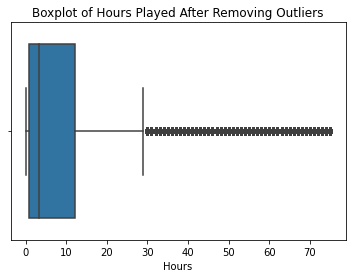

In [19]:
# Calculate IQR for 'Hours'
Q1 = filtered_data_new['Hours'].quantile(0.25)
Q3 = filtered_data_new['Hours'].quantile(0.75)
IQR = Q3 - Q1

# Define an upper bound for outliers
upper_bound = Q3 + 3 * IQR

# Removing outliers from 'Hours'
cleaned_dataset = filtered_data_new[filtered_data_new['Hours'] <= upper_bound]

# New basic statistics  after removing outliers
cleaned_numerical_stats = cleaned_dataset.describe()

# Plotting the new distribution of 'Hours'
plt.figure(figsize=(6, 4))
sns.boxplot(x=cleaned_dataset['Hours'])
plt.title('Boxplot of Hours Played After Removing Outliers')
plt.show()

In [20]:
outliers_removed = filtered_data_new.shape[0] - cleaned_dataset.shape[0]

In [21]:
outliers_removed

7024

In [22]:
filtered_data_new.shape

(69432, 6)

In [23]:
cleaned_dataset.shape

(62408, 6)

Function to print the games played by a user

In [24]:
def get_user_games(user_id, dataset):
 
    # Filter the DataFrame for the specified user
    user_interactions = dataset[dataset['UserID'] == user_id]

    # Extract the list of games played by the user
    games_played = user_interactions['Game'].tolist()

    return games_played


user_id_of_interest = 142793906  # Replace with the actual user ID
user_games = get_user_games(user_id_of_interest, cleaned_dataset)

# Print the games played or interacted with by the user
for game in user_games:
    print(game)


Dota 2
Garry's Mod
Orcs Must Die! 2
Killing Floor
Counter-Strike Global Offensive
DayZ
The Binding of Isaac
Outlast
Risk of Rain
Nosgoth
Awesomenauts
Alan Wake
Rocketbirds Hardboiled Chicken
Contagion
H1Z1
Warframe
Clicker Heroes
Dirty Bomb
Command and Conquer Red Alert 3
The Forest
Sanctum 2
How to Survive
Rise of Incarnates
Hammerwatch
Sakura Clicker
Aura Kingdom
Yet Another Zombie Defense
Wanderlust Rebirth
Deadlight
Fairy Bloom Freesia
Aces Wild Manic Brawling Action!


Export the final cleaned data to final clean data set csv file

In [ ]:
# cleaned_dataset.to_csv('./data/final_clean_dataset.csv')

// Uncomment to run GridSearch search to find the best params for SVD++ with new dataset

In [26]:
from surprise import Dataset, Reader
from surprise.model_selection import GridSearchCV
from surprise import SVDpp

# # Prepare the data for Surprise
reader = Reader(rating_scale=(cleaned_dataset['Ratings'].min(), cleaned_dataset['Ratings'].max()))
data = Dataset.load_from_df(cleaned_dataset[['UserID', 'Game', 'Ratings']], reader)

# # Define a range of hyperparameters
param_grid = {'n_factors': [50, 100, 150],  # Number of factors
              'n_epochs': [20, 30],  # Number of epochs
              'lr_all': [0.005, 0.01],  # Learning rate
              'reg_all': [0.02, 0.1],  # Regularization term
              'random_state': [42]    # random_state
             }

# # GridSearchCV with SVD++
gs_svdpp = GridSearchCV(SVDpp, param_grid, measures=['rmse', 'mae'], cv=5, n_jobs=-1)

# # Fit the model
svdp_model = gs_svdpp.fit(data)

# # Best score and parameters
best_rmse = gs_svdpp.best_score['rmse']
best_params = gs_svdpp.best_params['rmse']

print(f"Best RMSE: {best_rmse}")
print(f"Best parameters: {best_params}")

Best RMSE: 0.1886502658295503
Best parameters: {'n_factors': 50, 'n_epochs': 30, 'lr_all': 0.01, 'reg_all': 0.1, 'random_state': 42}


In [27]:
gs_svdpp.cv_results

{'split0_test_rmse': array([0.19123055, 0.18823042, 0.18867771, 0.18596125, 0.18943685,
        0.18661211, 0.1880224 , 0.18547056, 0.19728173, 0.19124863,
        0.19352059, 0.18773895, 0.19484432, 0.18888235, 0.19190592,
        0.18660167, 0.20136433, 0.19236376, 0.19627524, 0.18806522,
        0.19817465, 0.18953233, 0.19379683, 0.18660189]),
 'split1_test_rmse': array([0.19685906, 0.19391048, 0.19404826, 0.19118757, 0.19493237,
        0.19206355, 0.19320179, 0.19033635, 0.20279328, 0.19639798,
        0.19864521, 0.19251283, 0.20013022, 0.19383497, 0.19687546,
        0.19115806, 0.20482585, 0.19703052, 0.20027617, 0.19298395,
        0.20194197, 0.1943889 , 0.19824151, 0.19150713]),
 'split2_test_rmse': array([0.19518331, 0.19208987, 0.1924274 , 0.18953749, 0.19329834,
        0.19033337, 0.19151016, 0.18872596, 0.19842356, 0.19249543,
        0.19449684, 0.18919778, 0.19588414, 0.19026845, 0.19281286,
        0.18813828, 0.20486097, 0.19536034, 0.20003435, 0.19114111,
        

In [28]:
results_df = pd.DataFrame.from_dict(gs_svdpp.cv_results)

In [29]:
results_df

,split0_test_rmse,split1_test_rmse,split2_test_rmse,split3_test_rmse,split4_test_rmse,mean_test_rmse,std_test_rmse,rank_test_rmse,split0_test_mae,split1_test_mae,...,mean_fit_time,std_fit_time,mean_test_time,std_test_time,params,param_n_factors,param_n_epochs,param_lr_all,param_reg_all,param_random_state
0,0.191231,0.196859,0.195183,0.197053,0.192605,0.194586,0.002315,16,0.104092,0.107470,...,37.994642,0.564866,0.387524,0.005693,"{'n_factors': 50, 'n_epochs': 20, 'lr_all': 0....",50,20,0.005,0.02,42
1,0.188230,0.193910,0.192090,0.194066,0.190050,0.191669,0.002253,10,0.100774,0.103957,...,37.938048,0.660189,0.383997,0.007836,"{'n_factors': 50, 'n_epochs': 20, 'lr_all': 0....",50,20,0.005,0.10,42
2,0.188678,0.194048,0.192427,0.194580,0.190402,0.192027,0.002219,11,0.102857,0.106041,...,38.643043,1.106216,0.394571,0.005265,"{'n_factors': 50, 'n_epochs': 20, 'lr_all': 0....",50,20,0.010,0.02,42
3,0.185961,0.191188,0.189537,0.191698,0.188031,0.189283,0.002104,3,0.100123,0.102986,...,39.441640,0.319148,0.400653,0.007992,"{'n_factors': 50, 'n_epochs': 20, 'lr_all': 0....",50,20,0.010,0.10,42
4,0.189437,0.194932,0.193298,0.195317,0.191021,0.192801,0.002263,13,0.102940,0.106216,...,57.442956,1.064517,0.384228,0.009859,"{'n_factors': 50, 'n_epochs': 30, 'lr_all': 0....",50,30,0.005,0.02,42
5,0.186612,0.192064,0.190333,0.192416,0.188586,0.190002,0.002176,5,0.099950,0.102926,...,56.787130,0.933851,0.378199,0.007538,"{'n_factors': 50, 'n_epochs': 30, 'lr_all': 0....",50,30,0.005,0.10,42
6,0.188022,0.193202,0.191510,0.193928,0.189874,0.191307,0.002161,8,0.102060,0.105026,...,56.908854,0.915097,0.380346,0.008784,"{'n_factors': 50, 'n_epochs': 30, 'lr_all': 0....",50,30,0.010,0.02,42
7,0.185471,0.190336,0.188726,0.191085,0.187633,0.188650,0.001996,1,0.099788,0.102467,...,59.419784,0.442030,0.399108,0.008208,"{'n_factors': 50, 'n_epochs': 30, 'lr_all': 0....",50,30,0.010,0.10,42
8,0.197282,0.202793,0.198424,0.201685,0.198425,0.199722,0.002126,22,0.109574,0.113510,...,68.348268,0.994452,0.399246,0.008344,"{'n_factors': 100, 'n_epochs': 20, 'lr_all': 0...",100,20,0.005,0.02,42
9,0.191249,0.196398,0.192495,0.195984,0.192163,0.193658,0.002112,14,0.102801,0.106273,...,67.239560,1.197833,0.390979,0.008804,"{'n_factors': 100, 'n_epochs': 20, 'lr_all': 0...",100,20,0.005,0.10,42


We will fit the data on the full train set with the optimized `SVDpp` model using the best hyperparameters

In [25]:
# Load the full dataset from the dataframe
reader = Reader(rating_scale=(cleaned_dataset['Ratings'].min(), cleaned_dataset['Ratings'].max()))
data = Dataset.load_from_df(cleaned_dataset[['UserID', 'Game', 'Ratings']], reader)

# Build the full trainset
full_trainset = data.build_full_trainset()

# Set up the SVD++ algorithm with the given best parameters
algo = SVDpp(n_factors=50, n_epochs=30, lr_all=0.01, reg_all=0.1, random_state=42)

# Fit the algorithm on the full trainset
algo.fit(full_trainset)

In [40]:
def get_top_n_recommendations(algo, trainset, n=10):
    # First map the predictions to each user
    top_n = defaultdict(list)
    for inner_uid in trainset.all_users():
        # Retrieve the inner ids of items that the user has already rated
        user_items = set([j for (j, _) in trainset.ur[inner_uid]])
        # Predict ratings for all items the user hasn't rated
        user_ratings = [(trainset.to_raw_iid(inner_iid), algo.predict(trainset.to_raw_uid(inner_uid), trainset.to_raw_iid(inner_iid)).est)
                        for inner_iid in trainset.all_items()
                        if inner_iid not in user_items]
        # Retrieve the top N highest-rated items for this user
        top_n[trainset.to_raw_uid(inner_uid)].extend(sorted(user_ratings, key=lambda x: x[1], reverse=True)[:n])
    
    return top_n

# Using the best SVD++ estimator from GridSearchCV results and full trainset
top_n_recommendations = get_top_n_recommendations(algo, full_trainset, n=10)

# Display the recommendations for the first few users for demonstration
for user, user_recommendations in list(top_n_recommendations.items())[:5]:
    print(f"User: {user}")
    for item, rating in user_recommendations:
        print(f"\tI: {item}, Estimated Rating: {rating}")

User: 59945701
	I: Color Symphony, Estimated Rating: 0.5782096129480394
	I: Gladiators Online Death Before Dishonor, Estimated Rating: 0.5695971082595016
	I: Battle Battalions, Estimated Rating: 0.5612957806100842
	I: Let the Cat In, Estimated Rating: 0.5454167538833639
	I: DeathSpank, Estimated Rating: 0.5359164248042716
	I: Layers of Fear, Estimated Rating: 0.5329383559547854
	I: Super House of Dead Ninjas, Estimated Rating: 0.5291551302759325
	I: The Old Tree, Estimated Rating: 0.5287131942402388
	I: Skyborn, Estimated Rating: 0.5251101433985266
	I: Back to the Future Ep 1 - It's About Time, Estimated Rating: 0.5217852454624861
User: 54103616
	I: Battle Battalions, Estimated Rating: 0.6382916872960064
	I: Color Symphony, Estimated Rating: 0.6242452867053326
	I: Gladiators Online Death Before Dishonor, Estimated Rating: 0.6146296322906977
	I: Back to the Future Ep 1 - It's About Time, Estimated Rating: 0.6090440903112027
	I: Aeon Command, Estimated Rating: 0.6031602791859512
	I: Deat

In [42]:
def get_recommendations_for_random_users(algo, full_trainset, n=10, num_users=3):
    """Generate top-n recommendations for a random sample of users."""
    top_n = defaultdict(list)
    
    # Get a random sample of users from the trainset
    all_users = list(full_trainset.all_users())
    random_users = random.sample(all_users, num_users)
    
    for inner_uid in random_users:
        # Retrieve the inner ids of items that the user has already rated
        user_items = set([j for (j, _) in full_trainset.ur[inner_uid]])
        # Predict ratings for all items the user hasn't rated
        user_ratings = [(full_trainset.to_raw_iid(inner_iid), algo.predict(full_trainset.to_raw_uid(inner_uid), full_trainset.to_raw_iid(inner_iid)).est)
                        for inner_iid in full_trainset.all_items()
                        if inner_iid not in user_items]
        # Retrieve the top N highest-rated items for this user
        top_n[full_trainset.to_raw_uid(inner_uid)].extend(sorted(user_ratings, key=lambda x: x[1], reverse=True)[:n])
    
    return top_n

# Generate recommendations for a random sample of users
num_random_users = 3 
random_user_recommendations = get_recommendations_for_random_users(algo, full_trainset, n=10, num_users=num_random_users)

# Display the recommendations for the sampled users
for user, user_recommendations in random_user_recommendations.items():
    print(f"User: {user}")
    for item, rating in user_recommendations:
        print(f"\tGame: {item}, Estimated Rating: {rating}")

User: 86689730
	Game: Color Symphony, Estimated Rating: 0.6139218766031554
	Game: A Valley Without Wind, Estimated Rating: 0.5949576273985905
	Game: Dwarfs!?, Estimated Rating: 0.5760385500452927
	Game: Teslagrad, Estimated Rating: 0.5704686967256921
	Game: Year Walk, Estimated Rating: 0.5671448380066577
	Game: Battle Battalions, Estimated Rating: 0.5640174670585979
	Game: Tales Runner, Estimated Rating: 0.563934725561116
	Game: Resident Evil Operation Raccoon City, Estimated Rating: 0.5626125165862148
	Game: Myst V, Estimated Rating: 0.560930321637594
	Game: Skyborn, Estimated Rating: 0.5583136421349517
User: 110226344
	Game: Battle Battalions, Estimated Rating: 0.6911235594599666
	Game: Gladiators Online Death Before Dishonor, Estimated Rating: 0.6172481271351777
	Game: Color Symphony, Estimated Rating: 0.6156356437736822
	Game: Holy Potatoes! A Weapon Shop?!, Estimated Rating: 0.5851286997290738
	Game: 140, Estimated Rating: 0.5822491467290773
	Game: Bob Came in Pieces, Estimated Ra

In [43]:
def get_recommendations_for_random_users(algo, full_trainset, n=10, num_users=5):
    """Generate top-n recommendations for a random sample of users."""
    top_n = defaultdict(list)
    
    # Get a random sample of users from the trainset
    all_users = list(full_trainset.all_users())
    random_users = random.sample(all_users, num_users)
    
    for inner_uid in random_users:
        # Retrieve the inner ids of items that the user has already rated
        user_items = set([j for (j, _) in full_trainset.ur[inner_uid]])
        # Predict ratings for all items the user hasn't rated
        user_ratings = [(full_trainset.to_raw_iid(inner_iid), algo.predict(full_trainset.to_raw_uid(inner_uid), full_trainset.to_raw_iid(inner_iid)).est)
                        for inner_iid in full_trainset.all_items()
                        if inner_iid not in user_items]
        # Retrieve the top N highest-rated items for this user
        top_n[full_trainset.to_raw_uid(inner_uid)].extend(sorted(user_ratings, key=lambda x: x[1], reverse=True)[:n])
    
    return top_n

# Generate recommendations for a random sample of users
num_random_users = 5 
random_user_recommendations = get_recommendations_for_random_users(algo, full_trainset, n=10, num_users=num_random_users)

# Display the recommendations for the sampled users
for user, user_recommendations in random_user_recommendations.items():
    print(f"User: {user}")
    for item, rating in user_recommendations:
        print(f"\tGame: {item}, Estimated Rating: {rating}")

User: 64366280
	Game: Battle Battalions, Estimated Rating: 0.7220785428722816
	Game: Gladiators Online Death Before Dishonor, Estimated Rating: 0.6857462221928419
	Game: Wolfenstein 3D, Estimated Rating: 0.6640038957913511
	Game: Skyborn, Estimated Rating: 0.6390399141128705
	Game: Color Symphony, Estimated Rating: 0.6358198135891827
	Game: Dr. Langeskov, The Tiger, and The Terribly Cursed Emerald A Whirlwind Heist, Estimated Rating: 0.6118940659041823
	Game: Year Walk, Estimated Rating: 0.610884066546258
	Game: TypeRider, Estimated Rating: 0.6009994512982231
	Game: Lego Star Wars 3 The Clone Wars, Estimated Rating: 0.596999385903468
	Game: Prince of Persia, Estimated Rating: 0.5966369076895026
User: 287613958
	Game: Gladiators Online Death Before Dishonor, Estimated Rating: 0.6116015604700271
	Game: Dynasty Warriors 8 - Empires, Estimated Rating: 0.6079263265772388
	Game: Color Symphony, Estimated Rating: 0.5997696161233618
	Game: Lego Star Wars 3 The Clone Wars, Estimated Rating: 0.5

In [41]:
df = pd.read_csv('./data/final_clean_dataset.csv')

### Save SVDpp model as a pickle file for deployment

In [45]:
model_filename = 'svdpp_model.pkl'
with open(model_filename, 'wb') as file:
    pickle.dump(algo, file)

In [46]:
# use the pickled model to predict 
def get_recommendations(user_id, n=5):
    
    with open("svdpp_model.pkl", "rb") as f:
        svdpp  = pickle.load(f)
    # Convert the user_id input from string to integer
    user_id = int(user_id)
    # Get inner user id from the raw user id
    inner_user_id = full_trainset.to_inner_uid(user_id)
    # Now we can get recommendations for the specific user
    user_recommendations = defaultdict(list)
    user_items = set([j for (j, _) in full_trainset.ur[inner_user_id]])
    user_ratings = [(full_trainset.to_raw_iid(inner_iid), svdpp.predict(user_id, full_trainset.to_raw_iid(inner_iid)).est)
                    for inner_iid in full_trainset.all_items()
                    if inner_iid not in user_items]
    user_recommendations[user_id].extend(sorted(user_ratings, key=lambda x: x[1], reverse=True)[:n])
    return user_recommendations[user_id]



In [47]:
def get_user_games(user_id, df):
    
    user_games = df[df['UserID'] == int(user_id)]['Game'].tolist()
    return user_games


In [48]:
def recommend_and_show_played_games(user_id):
    try:
        # Get the list of games the user has already played
        played_games = get_user_games(user_id, df)
        # Get recommendations for the user
        recommendations = get_recommendations(user_id)
        
        # Format the played games and recommendations into strings
        played_games_str = "Games Played:\n" + "\n".join(played_games)
        recommendations_str = "\nRecommended Games:\n" + "\n".join([f"{game}: {rating:.2f}" for game, rating in recommendations])
        
        # Return both strings
        return played_games_str + "\n\n" + recommendations_str
    except Exception as e:
        return str(e)


In [49]:
# Function for error handling Gradio
def recommend_games(user_id):
    try:
        # Convert user_id to the expected type, e.g., integer
        user_id = int(user_id)
        
        recommendations = get_recommendations(user_id)
        
        # Format the recommendations into a string or a list to return through Gradio
        return '\n'.join([f"{game}: {rating:.2f}" for game, rating in recommendations])
    except ValueError:
        return "Invalid user ID format. Please enter a numeric user ID."
    except KeyError:
        return "User ID not found in the dataset."
    except Exception as e:
        # Generic error handling for any other unexpected errors
        return str(e)

### Web app based on the pickled model predictions 

In [50]:
interface = gr.Interface(
    title="Recommendation System for Steam Games",
    article="Input Steam user_id and generate the top 5 recommended games",
    fn=recommend_and_show_played_games,
    inputs="text",
    outputs="text",
    examples=[["Enter User ID here"]]
)

interface.launch(share=True)

Running on local URL:  http://127.0.0.1:7868
Running on public URL: https://9f9bc618fba5c54ebc.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


## Next Steps

In the next phase of the project, users will have the opportunity to input their unique user_id through API calls, enabling the system to provide personalized game recommendations tailored to their gaming preferences. This interactive feature enhances the user experience by delivering targeted suggestions based on individual gaming histories. By leveraging API functionality, the recommendation system ensures a dynamic and user-centric approach, fostering greater engagement and satisfaction within the gaming community.